In [58]:
import pandas as pd 
import io
import math
from tqdm import tqdm
import multiprocess as mp 
import dask.dataframe as dd
import requests

centroid_stops = [82,192]

endpoints_by_yr = [
    'https://data.ny.gov/resource/rapa-97zv.csv', 
    'https://data.ny.gov/resource/nqnz-e9z9.csv', 
    'https://data.ny.gov/resource/uhf3-t34z.csv',
    'https://data.ny.gov/resource/jsu2-fbtj.csv',
    'https://data.ny.gov/resource/y2qv-fytt.csv'
]

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

def compute_yearly(endpoint, demand_stations, origin_station_id=['82','192']):

    #retrieve request
    def build_tbl(endpoint, payload):
        try:
            r = requests.get(
                url = endpoint, params = payload
            ) 
            return pd.read_csv(io.StringIO(r.text))
        except Exception:
            print(r.status_code) 
            print(r.reason) 
            return pd.DataFrame() 
            
    stations_str = ','.join(origin_station_id) if type(origin_station_id) != str else origin_station_id
    demand_stations_str = ','.join(demand_stations) if type(demand_stations) != str else demand_stations
    
    #retrieve inbound/outbound ridership, across whole system and within qns
    payloads = [
        {
            '$select':'destination_station_complex_id,SUM(estimated_average_ridership) as outbound_ridership',
            '$where':f"origin_station_complex_id in ({stations_str}) and destination_station_complex_id in ({demand_stations_str})",
            '$group':'destination_station_complex_id',
            '$limit':50000
        }, 
        {
            '$select':'origin_station_complex_id,SUM(estimated_average_ridership) as inbound_ridership',
            '$where':f"destination_station_complex_id in ({stations_str}) and origin_station_complex_id in ({demand_stations_str})",
            '$group':'origin_station_complex_id',
            '$limit':50000
        }
        
    ]

    #use the multicore to speed things up
    pool = mp.Pool(processes=4)
    mapped = pool.map(lambda x: build_tbl(endpoint = endpoint, payload = x), payloads)

    in_, out_ = mapped 
    combined = in_.merge(
        out_, 
        how='inner', 
        left_on='destination_station_complex_id', 
        right_on='origin_station_complex_id',
    )

    combined = combined.drop(columns=['destination_station_complex_id'])
    combined = combined.rename(
        columns={'origin_station_complex_id':'Complex ID'}
    )
    combined['ttl_ridership'] = combined['outbound_ridership']+combined['inbound_ridership']
    combined = combined.set_index('Complex ID')
    normalized = combined.div(combined.sum(axis=0),axis=1)
    
    return normalized


station_metadata=pd.read_csv('datasets/MTA_Subway_Entrances_and_Exits__2024_20250417.csv')

#find qns stations along the qns blvd line, the roosevelt ave line (7), and the astoria line (N,W)
#basically anywhere in queens easily served by qnslink

#address weird M-train branch in Ridgewood ...this is difficult to reach via queenslink
middle_village = [40.7126801,-73.8888057]

qns_stations = station_metadata.loc[
    (station_metadata['Borough']=='Q')
   &(~station_metadata['Daytime Routes'].str.contains('A|C|J|Z'))
   &(station_metadata['Entrance Latitude'] > middle_village[0])
]
qns_stations_tr = qns_stations[['Stop Name','Complex ID','Daytime Routes']].drop_duplicates()
qns_stations_lst = ','.join(qns_stations['Complex ID'].unique().astype(str))

#find manh stations that are likely to be reached more easily via qnslink 
#use the flatiron building as the spatial threshold 
flatiron_bldg = [40.7412928,-73.9900236]

manh_stations = station_metadata.loc[
    (station_metadata['Borough']=='M')
   &(station_metadata['Entrance Latitude'] > flatiron_bldg[0])
]
manh_stations_tr = manh_stations[['Stop Name','Complex ID','Daytime Routes']].drop_duplicates()
manh_stations_lst = ','.join(manh_stations['Complex ID'].unique().astype(str))
all_stations_lst = f'{qns_stations_lst},{manh_stations_lst}'

#find infill stations near qnslink transfer points, set radius 
lat_lon = station_metadata\
            .groupby(['Complex ID'])[[
                'Entrance Latitude',
                'Entrance Longitude'
                ]]\
            .mean() \
            .reset_index()

centroids = lat_lon.loc[lat_lon['Complex ID'].isin(centroid_stops)]

for i,r in centroids.iterrows(): 
    ref_lat, ref_lon = r['Entrance Latitude'],r['Entrance Longitude'] 
    lat_lon[f"distance_{r['Complex ID']}"] = \
    lat_lon.apply(lambda r: haversine(ref_lat,ref_lon,r['Entrance Latitude'],r['Entrance Longitude']),axis=1)
    

max_radius = 2 

study_area = lat_lon.loc[
    (lat_lon['distance_82.0'] < max_radius)
   &(lat_lon['distance_192.0'] < max_radius)
]
study_area_complex = study_area['Complex ID'].unique().astype(str)

station_ridership = compute_yearly(
    endpoints_by_yr[-2], 
    all_stations_lst,
    origin_station_id=study_area_complex
)

station_geos = station_metadata[['Complex ID', 'Entrance Latitude', 'Entrance Longitude']].groupby(['Complex ID']).mean()

ridership_w_geos = pd.concat((station_geos,station_ridership),axis=1).dropna()
ridership_w_geos.head(10)

,Entrance Latitude,Entrance Longitude,outbound_ridership,inbound_ridership,ttl_ridership
Complex ID,,,,,
1,40.774975,-73.912086,0.001434,0.001692,0.001565
2,40.770615,-73.917463,0.001048,0.001145,0.001097
3,40.766983,-73.921299,0.001089,0.001189,0.001139
4,40.761846,-73.925476,0.000629,0.000673,0.000651
5,40.756568,-73.929827,0.000480,0.000503,0.000492
6,40.752697,-73.932923,0.000273,0.000213,0.000243
8,40.764979,-73.973332,0.002539,0.002673,0.002607
9,40.764870,-73.980520,0.003637,0.002745,0.003185
10,40.759983,-73.984107,0.002684,0.002187,0.002432


/var/folders/wx/wz1pbs1903j_cfgqws400dz80000gn/T/ipykernel_57470/3841926337.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sample['geometry'] = sample['geometry'].buffer(sample['ttl_ridership']*0.15)


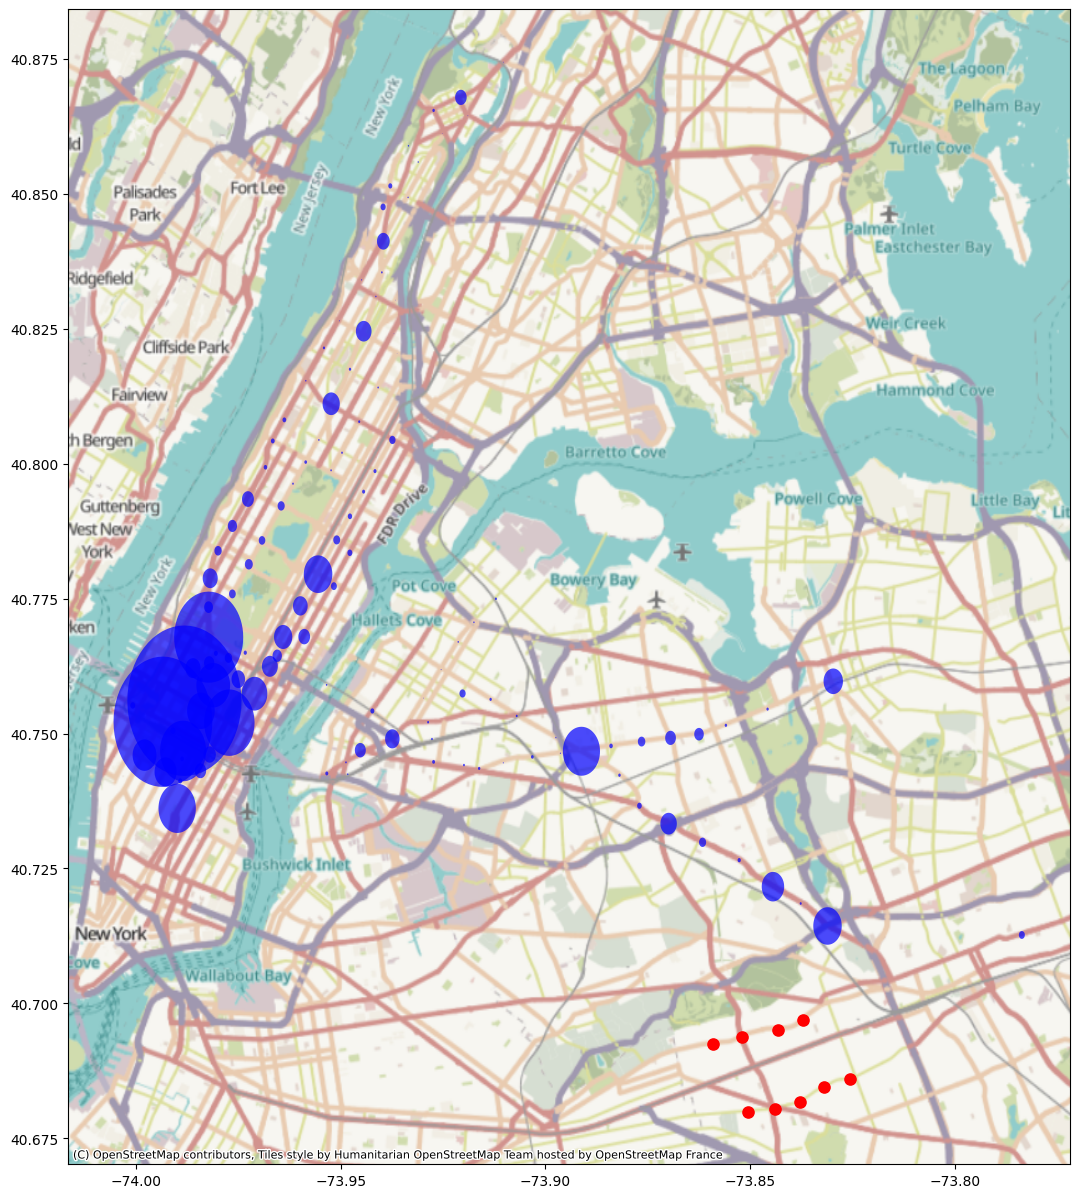

In [68]:
from shapely.geometry import Point

import geopandas as gpd
import contextily as cx

import matplotlib.pyplot as plt

ridership_w_geos['geometry'] = ridership_w_geos.apply(lambda x: Point((x['Entrance Longitude'], x['Entrance Latitude'])), axis = 1)
study_area['geometry'] = study_area.apply(lambda x: Point((x['Entrance Longitude'], x['Entrance Latitude'])), axis = 1)

ridership_w_geos_gpd = gpd.GeoDataFrame(ridership_w_geos, crs="EPSG:4326")
study_area = gpd.GeoDataFrame(study_area, crs="EPSG:4326")
sample = ridership_w_geos_gpd.copy()
sample['geometry'] = sample['geometry'].buffer(sample['ttl_ridership']*0.15)
#study_area['geometry'] = study_area['geometry'].buffer(0.003)

fig, ax = plt.subplots(figsize=(15, 15))
sample.plot(
    ax=ax, 
    alpha=0.7, 
    color="blue", 
    label='Queenslink Demand Service Stations', 
    legend=True, 
    legend_kwds={'loc': 'upper right'}
)
study_area.plot(
    ax=ax, 
    alpha=1, 
    color='red', 
    label='Queenslink Demand Proximity Zone Stations', 
    legend=True, 
    legend_kwds={'loc': 'upper right'},
    markersize=65
)

cx.add_basemap(ax, crs=ridership_w_geos_gpd.crs)

plt.show()